In [1]:
# Cell 1: Imports & Seed
import os, json, random, numpy as np, tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, CSVLogger
from tensorflow.keras.regularizers import l2
from keras.applications.inception_v3 import InceptionV3, preprocess_input

try:
    from sklearn.metrics import classification_report, confusion_matrix
    SKLEARN = True
except Exception:
    SKLEARN = False

def set_seed(seed=42):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed); np.random.seed(seed); tf.random.set_seed(seed)

set_seed(42)
print("TF:", tf.__version__)


TF: 2.19.0


In [2]:
# Cell 2: CONFIG (여기 경로만 수정하세요)
DATA_ROOT = r"C:\Users\moont\Desktop\2025miniinterncode\lumbar_spinal_dataset"  # <- 당신 경로
CONFIG = {
    "TRAIN_DIR": os.path.join(DATA_ROOT, "training"),
    "TEST_DIR":  os.path.join(DATA_ROOT, "testing"),
    "VAL_SPLIT": 0.2,              # training에서 validation 비율
    "IMG_SIZE": (299, 299),        # InceptionV3 권장 입력
    "BATCH_SIZE": 32,
    "SEED": 42,
    "LABEL_MODE": "int",           # sparse labels

    "WARMUP_EPOCHS": 5,
    "FINETUNE_EPOCHS": 20,
    "UNFREEZE_TOP_N_LAYERS": 60,
    "LR_WARMUP": 3e-4,
    "LR_FINETUNE": 1e-4,
    "DROPOUT": 0.4,
    "L2_WEIGHT_DECAY": 1e-4,

    "EARLYSTOP_PATIENCE": 6,
    "PLATEAU_FACTOR": 0.5,
    "PLATEAU_PATIENCE": 3,
    "MIN_LR": 1e-6,

    "USE_CLASS_WEIGHTS": True,
    "OUTPUT_DIR": "./outputs_inceptionv3",
    "MODEL_NAME": "inceptionv3_finetuned",
}
os.makedirs(CONFIG["OUTPUT_DIR"], exist_ok=True)
print(json.dumps(CONFIG, indent=2))


{
  "TRAIN_DIR": "C:\\Users\\moont\\Desktop\\2025miniinterncode\\lumbar_spinal_dataset\\training",
  "TEST_DIR": "C:\\Users\\moont\\Desktop\\2025miniinterncode\\lumbar_spinal_dataset\\testing",
  "VAL_SPLIT": 0.2,
  "IMG_SIZE": [
    299,
    299
  ],
  "BATCH_SIZE": 32,
  "SEED": 42,
  "LABEL_MODE": "int",
  "WARMUP_EPOCHS": 5,
  "FINETUNE_EPOCHS": 20,
  "UNFREEZE_TOP_N_LAYERS": 60,
  "LR_WARMUP": 0.0003,
  "LR_FINETUNE": 0.0001,
  "DROPOUT": 0.4,
  "L2_WEIGHT_DECAY": 0.0001,
  "EARLYSTOP_PATIENCE": 6,
  "PLATEAU_FACTOR": 0.5,
  "PLATEAU_PATIENCE": 3,
  "MIN_LR": 1e-06,
  "USE_CLASS_WEIGHTS": true,
  "OUTPUT_DIR": "./outputs_inceptionv3",
  "MODEL_NAME": "inceptionv3_finetuned"
}


In [3]:
# Cell 3: GPU 메모리 그로스
try:
    gpus = tf.config.experimental.list_physical_devices('GPU')
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    print(f"[Info] GPUs: {len(gpus)}")
except Exception as e:
    print("[Warn] GPU setup skipped:", e)


[Info] GPUs: 0


In [4]:
# Cell 4: Build datasets (CONSISTENT class order)
def build_datasets(cfg):
    img_size = cfg["IMG_SIZE"]; bs = cfg["BATCH_SIZE"]; seed = cfg["SEED"]

    # 1) 학습 폴더에서 '정식' 클래스 순서를 하나로 고정
    CANONICAL_CLASSES = sorted([
        d for d in os.listdir(cfg["TRAIN_DIR"])
        if os.path.isdir(os.path.join(cfg["TRAIN_DIR"], d))
    ])
    print("[CANONICAL_CLASSES]", CANONICAL_CLASSES)

    # 2) train/val: training에서 분할, test: testing 사용
    train_raw = keras.preprocessing.image_dataset_from_directory(
        cfg["TRAIN_DIR"], image_size=img_size, batch_size=bs, seed=seed,
        validation_split=cfg["VAL_SPLIT"], subset="training",
        label_mode=cfg["LABEL_MODE"], color_mode="rgb", shuffle=True,
        class_names=CANONICAL_CLASSES  # <<< 고정!
    )
    val_raw = keras.preprocessing.image_dataset_from_directory(
        cfg["TRAIN_DIR"], image_size=img_size, batch_size=bs, seed=seed,
        validation_split=cfg["VAL_SPLIT"], subset="validation",
        label_mode=cfg["LABEL_MODE"], color_mode="rgb", shuffle=False,
        class_names=CANONICAL_CLASSES  # <<< 고정!
    )
    test_raw = keras.preprocessing.image_dataset_from_directory(
        cfg["TEST_DIR"], image_size=img_size, batch_size=bs, seed=seed,
        label_mode=cfg["LABEL_MODE"], color_mode="rgb", shuffle=False,
        class_names=CANONICAL_CLASSES  # <<< 고정!
    )

    # 가벼운 증강 + InceptionV3 전처리(중복 정규화 금지)
    augment = keras.Sequential([
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.05),
        layers.RandomZoom(0.10),
        layers.RandomTranslation(0.05, 0.05),
    ], name="augment")
    AUTOTUNE = tf.data.AUTOTUNE
    def tr_map(x, y): return preprocess_input(augment(x)), y
    def ev_map(x, y): return preprocess_input(x), y

    train_ds = train_raw.map(tr_map, num_parallel_calls=AUTOTUNE)\
                        .shuffle(1000, seed=seed).prefetch(AUTOTUNE)
    val_ds   = val_raw.map(ev_map,   num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)
    test_ds  = test_raw.map(ev_map,  num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)

    # 매핑 확인(세 세트가 반드시 동일해야 함)
    print("train:", train_raw.class_names)
    print("val:  ", val_raw.class_names)
    print("test: ", test_raw.class_names)

    return train_raw, train_ds, val_ds, test_ds, CANONICAL_CLASSES

train_raw, train_ds, val_ds, test_ds, class_names = build_datasets(CONFIG)
NUM_CLASSES = len(class_names)
print("Classes:", class_names)


[CANONICAL_CLASSES] ['Herniated_Disc', 'No_Stenosis', 'Thecal_Sac']
Found 4808 files belonging to 3 classes.
Using 3847 files for training.
Found 4808 files belonging to 3 classes.
Using 961 files for validation.
Found 1158 files belonging to 3 classes.
train: ['Herniated_Disc', 'No_Stenosis', 'Thecal_Sac']
val:   ['Herniated_Disc', 'No_Stenosis', 'Thecal_Sac']
test:  ['Herniated_Disc', 'No_Stenosis', 'Thecal_Sac']
Classes: ['Herniated_Disc', 'No_Stenosis', 'Thecal_Sac']


In [5]:
# Cell 5: Class weights from train_raw
import numpy as np

def compute_class_weights(ds_raw, n_classes):
    counts = np.zeros(n_classes, dtype=np.int64)
    for _, y in ds_raw.unbatch().batch(4096):
        y = y.numpy().astype(int)
        for i in y: counts[int(i)] += 1
    total = counts.sum()
    counts = np.where(counts == 0, 1, counts)
    weights = {i: float(total) / (n_classes * float(counts[i])) for i in range(n_classes)}
    print("[Class counts]", counts.tolist()); print("[Class weights]", weights)
    return weights

CLASS_WEIGHTS = compute_class_weights(train_raw, NUM_CLASSES) if CONFIG["USE_CLASS_WEIGHTS"] else None


[Class counts] [1545, 1203, 1099]
[Class weights] {0: 0.8299892125134843, 1: 1.0659462454973676, 2: 1.1668183196845616}


In [6]:
# Cell 6: Build model
def build_model(cfg, num_classes):
    base = InceptionV3(include_top=False, weights="imagenet", input_shape=cfg["IMG_SIZE"] + (3,))
    base.trainable = False

    inputs = keras.Input(shape=cfg["IMG_SIZE"] + (3,))
    x = base(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(cfg["DROPOUT"])(x)
    x = layers.Dense(512, activation="relu", kernel_regularizer=l2(cfg["L2_WEIGHT_DECAY"]))(x)
    x = layers.Dropout(cfg["DROPOUT"])(x)
    outputs = layers.Dense(num_classes, activation="softmax", dtype="float32")(x)
    return keras.Model(inputs, outputs), base

model, base = build_model(CONFIG, NUM_CLASSES)
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inception_v3 (Functional)       │ (None, 8, 8, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,853,411 (87.18 MB)

 Trainable params: 1,050,627 (4.01 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [7]:
# Cell 7: Callbacks
ckpt_best = os.path.join(CONFIG["OUTPUT_DIR"], f"{CONFIG['MODEL_NAME']}_best.keras")
callbacks = [
    EarlyStopping(monitor="val_loss", patience=CONFIG["EARLYSTOP_PATIENCE"], restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=CONFIG["PLATEAU_FACTOR"],
                      patience=CONFIG["PLATEAU_PATIENCE"], min_lr=CONFIG["MIN_LR"]),
    ModelCheckpoint(ckpt_best, monitor="val_loss", save_best_only=True, verbose=1),
    CSVLogger(os.path.join(CONFIG["OUTPUT_DIR"], f"{CONFIG['MODEL_NAME']}_log.csv"))
]


In [8]:
# Cell 8: Stage 1
model.compile(
    optimizer=keras.optimizers.Adam(CONFIG["LR_WARMUP"]),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)
print("[Stage 1] backbone frozen")
hist1 = model.fit(
    train_ds, validation_data=val_ds,
    epochs=CONFIG["WARMUP_EPOCHS"], callbacks=callbacks,
    class_weight=CLASS_WEIGHTS
)


[Stage 1] backbone frozen
Epoch 1/5
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 817ms/step - accuracy: 0.3434 - loss: 1.4000
Epoch 1: val_loss improved from None to 1.08680, saving model to ./outputs_inceptionv3\inceptionv3_finetuned_best.keras
121/121 ━━━━━━━━━━━━━━━━━━━━ 143s 1s/step - accuracy: 0.3527 - loss: 1.3075 - val_accuracy: 0.5619 - val_loss: 1.0868 - learning_rate: 3.0000e-04
Epoch 2/5
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 823ms/step - accuracy: 0.3979 - loss: 1.1828
Epoch 2: val_loss improved from 1.08680 to 0.82671, saving model to ./outputs_inceptionv3\inceptionv3_finetuned_best.keras
121/121 ━━━━━━━━━━━━━━━━━━━━ 151s 1s/step - accuracy: 0.3910 - loss: 1.1892 - val_accuracy: 0.8949 - val_loss: 0.8267 - learning_rate: 3.0000e-04
Epoch 3/5
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 809ms/step - accuracy: 0.3890 - loss: 1.1713
Epoch 3: val_loss did not improve from 0.82671
121/121 ━━━━━━━━━━━━━━━━━━━━ 132s 1s/step - accuracy: 0.3962 - loss: 1.1641 - val_accuracy: 0.4422 - val_loss: 1.1491 - learning_ra

In [9]:
# Cell 9: Stage 2
def unfreeze_top_layers(base_model, n_layers=60):
    unfrozen = 0
    for layer in base_model.layers[-n_layers:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True
            unfrozen += 1
    print(f"[Info] Unfrozen {unfrozen}/{n_layers} (BatchNorm kept frozen)")

unfreeze_top_layers(base, CONFIG["UNFREEZE_TOP_N_LAYERS"])

model.compile(
    optimizer=keras.optimizers.Adam(CONFIG["LR_FINETUNE"]),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)
print("[Stage 2] fine-tuning")
hist2 = model.fit(
    train_ds, validation_data=val_ds,
    epochs=CONFIG["FINETUNE_EPOCHS"], callbacks=callbacks,
    class_weight=CLASS_WEIGHTS
)


[Info] Unfrozen 43/60 (BatchNorm kept frozen)
[Stage 2] fine-tuning
Epoch 1/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 985ms/step - accuracy: 0.3875 - loss: 1.1682
Epoch 1: val_loss did not improve from 0.82671
121/121 ━━━━━━━━━━━━━━━━━━━━ 158s 1s/step - accuracy: 0.4040 - loss: 1.1555 - val_accuracy: 0.2362 - val_loss: 1.1922 - learning_rate: 1.0000e-04
Epoch 2/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 957ms/step - accuracy: 0.4534 - loss: 1.1065
Epoch 2: val_loss did not improve from 0.82671
121/121 ━━━━━━━━━━━━━━━━━━━━ 147s 1s/step - accuracy: 0.4492 - loss: 1.1062 - val_accuracy: 0.3746 - val_loss: 1.1525 - learning_rate: 1.0000e-04
Epoch 3/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 957ms/step - accuracy: 0.4792 - loss: 1.0735
Epoch 3: val_loss did not improve from 0.82671
121/121 ━━━━━━━━━━━━━━━━━━━━ 147s 1s/step - accuracy: 0.4903 - loss: 1.0621 - val_accuracy: 0.4194 - val_loss: 1.0307 - learning_rate: 1.0000e-04
Epoch 4/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 952ms/step - accuracy: 0.5506 - loss: 1.0213
E

In [10]:
# Cell 10: Save & Evaluate
final_path = os.path.join(CONFIG["OUTPUT_DIR"], f"{CONFIG['MODEL_NAME']}_final.keras")
model.save(final_path); print("[Saved]", final_path)

loss, acc = model.evaluate(test_ds, verbose=0)
print(f"[TEST] Loss: {loss:.4f} | Acc: {acc:.4f}")


[Saved] ./outputs_inceptionv3\inceptionv3_finetuned_final.keras
[TEST] Loss: 2.2796 | Acc: 0.4577


[TEST counts by class index] {0: 257, 1: 289, 2: 612} | order= ['Herniated_Disc', 'No_Stenosis', 'Thecal_Sac']
                precision    recall  f1-score   support

Herniated_Disc     0.3346    0.6654    0.4453       257
   No_Stenosis     0.4598    0.4948    0.4767       289
    Thecal_Sac     0.6429    0.3529    0.4557       612

      accuracy                         0.4577      1158
     macro avg     0.4791    0.5044    0.4592      1158
  weighted avg     0.5288    0.4577    0.4586      1158



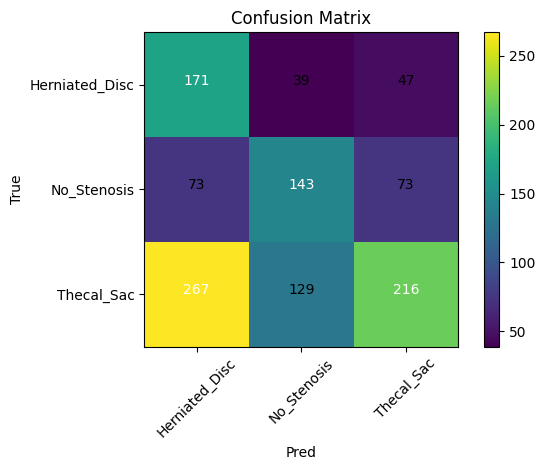

In [11]:
# Cell 11: Test sanity check & confusion matrix
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt, itertools

# 1) per-class 샘플 수
counts = {i:0 for i in range(NUM_CLASSES)}
for _, y in test_ds.unbatch().batch(4096):
    y = y.numpy().astype(int)
    for i in y: counts[int(i)] += 1
print("[TEST counts by class index]", counts, "| order=", class_names)

# 2) 예측/리포트
y_true, y_pred = [], []
for xb, yb in test_ds:
    p = model.predict(xb, verbose=0)
    y_pred.extend(np.argmax(p, axis=1).tolist())
    y_true.extend(yb.numpy().astype(int).tolist())

print(classification_report(y_true, y_pred, target_names=class_names, digits=4, zero_division=0))

# 3) 혼동행렬
cm = confusion_matrix(y_true, y_pred, labels=list(range(NUM_CLASSES)))
plt.figure()
plt.imshow(cm, interpolation='nearest'); plt.title('Confusion Matrix'); plt.colorbar()
tick = np.arange(NUM_CLASSES)
plt.xticks(tick, class_names, rotation=45); plt.yticks(tick, class_names)
th = cm.max()/2
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, str(cm[i, j]), ha="center",
             color="white" if cm[i, j] > th else "black")
plt.ylabel('True'); plt.xlabel('Pred'); plt.tight_layout(); plt.show()
